In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [18]:
img = cv2.imread('test2-afterotsu.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

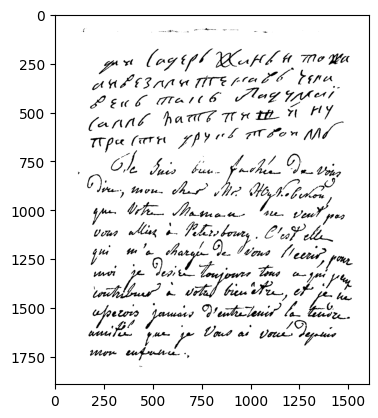

In [19]:
plt.imshow(gray_img, cmap='gray')
plt.savefig('img.pdf', format='pdf')

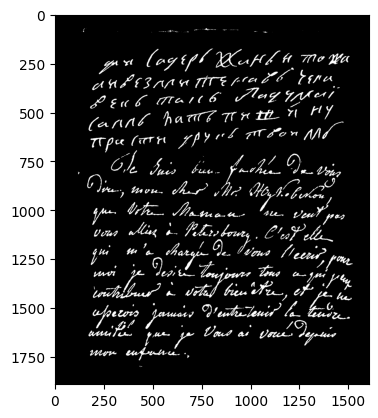

In [4]:
gray_img = np.array(gray_img)
_, bin_img = cv2.threshold(gray_img, 127.5, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(bin_img, cmap='gray')

In [5]:
ones_img = np.sum(bin_img, axis=1)
ones_img

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [43]:
#вычисляем точки экстремума столбиков распредления плотности
curr = 0
prev = 0
extrems = []
while curr < len(ones_img):
    while curr < len(ones_img) and ones_img[curr] < 210:
        curr += 1
    if curr < len(ones_img):
        mx = curr + np.argmax(ones_img[curr:curr+55])
        extrems.append(mx)
        curr += 55
len(extrems)

15

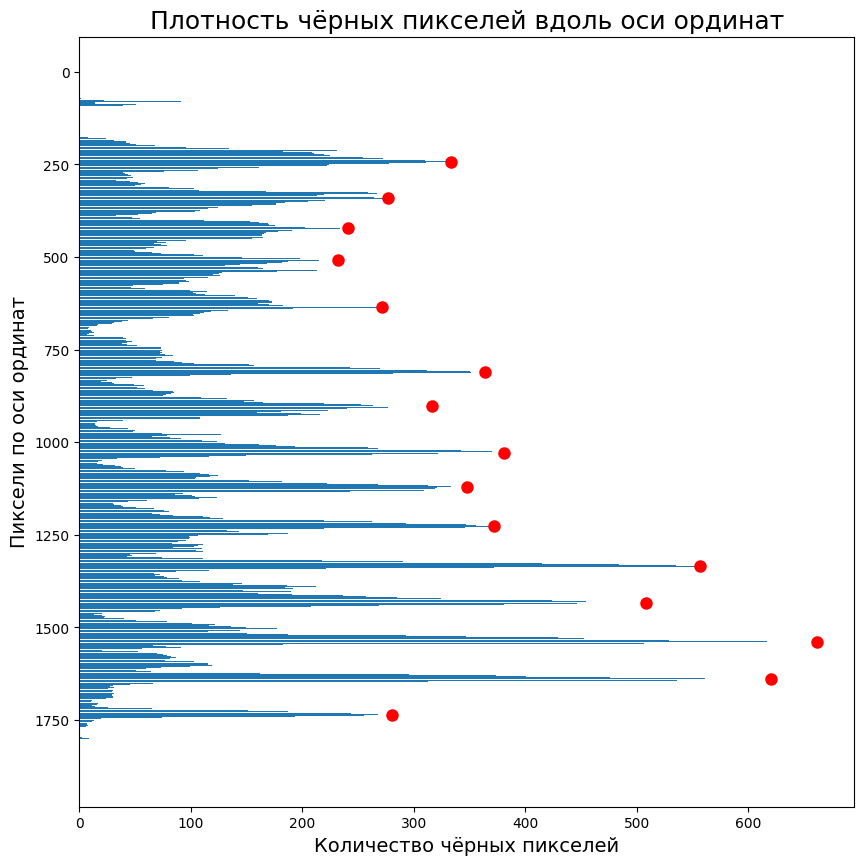

In [46]:
fig = plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(ones_img)), ones_img)
plt.gca().invert_yaxis()
plt.scatter(ones_img[extrems], extrems, c='r', linewidths=3)
plt.xlabel('Количество чёрных пикселей', fontsize=14)
plt.ylabel('Пиксели по оси ординат', fontsize=14)
plt.title('Плотность чёрных пикселей вдоль оси ординат', fontsize=18)
plt.savefig('density.pdf', format='pdf')
plt.show()

In [47]:
curr = 0
prev = 0
extrems = []
while curr < len(ones_img):
    while curr < len(ones_img) and ones_img[curr] < 210:
        curr += 1
    if curr < len(ones_img):
        mx = curr + np.argmax(ones_img[curr:curr+55])
        extrems.append(mx)
        curr += 55
len(extrems)

15

In [69]:
boarders = ones_img.copy()

In [70]:
#посчитаем дисперсию отклонений в найденных точках экстремума - это будет ширина наших строк
for p in extrems:
    x = np.array(boarders[p-40:p+40])
    E = np.mean(x)
    x[x < E] = 0

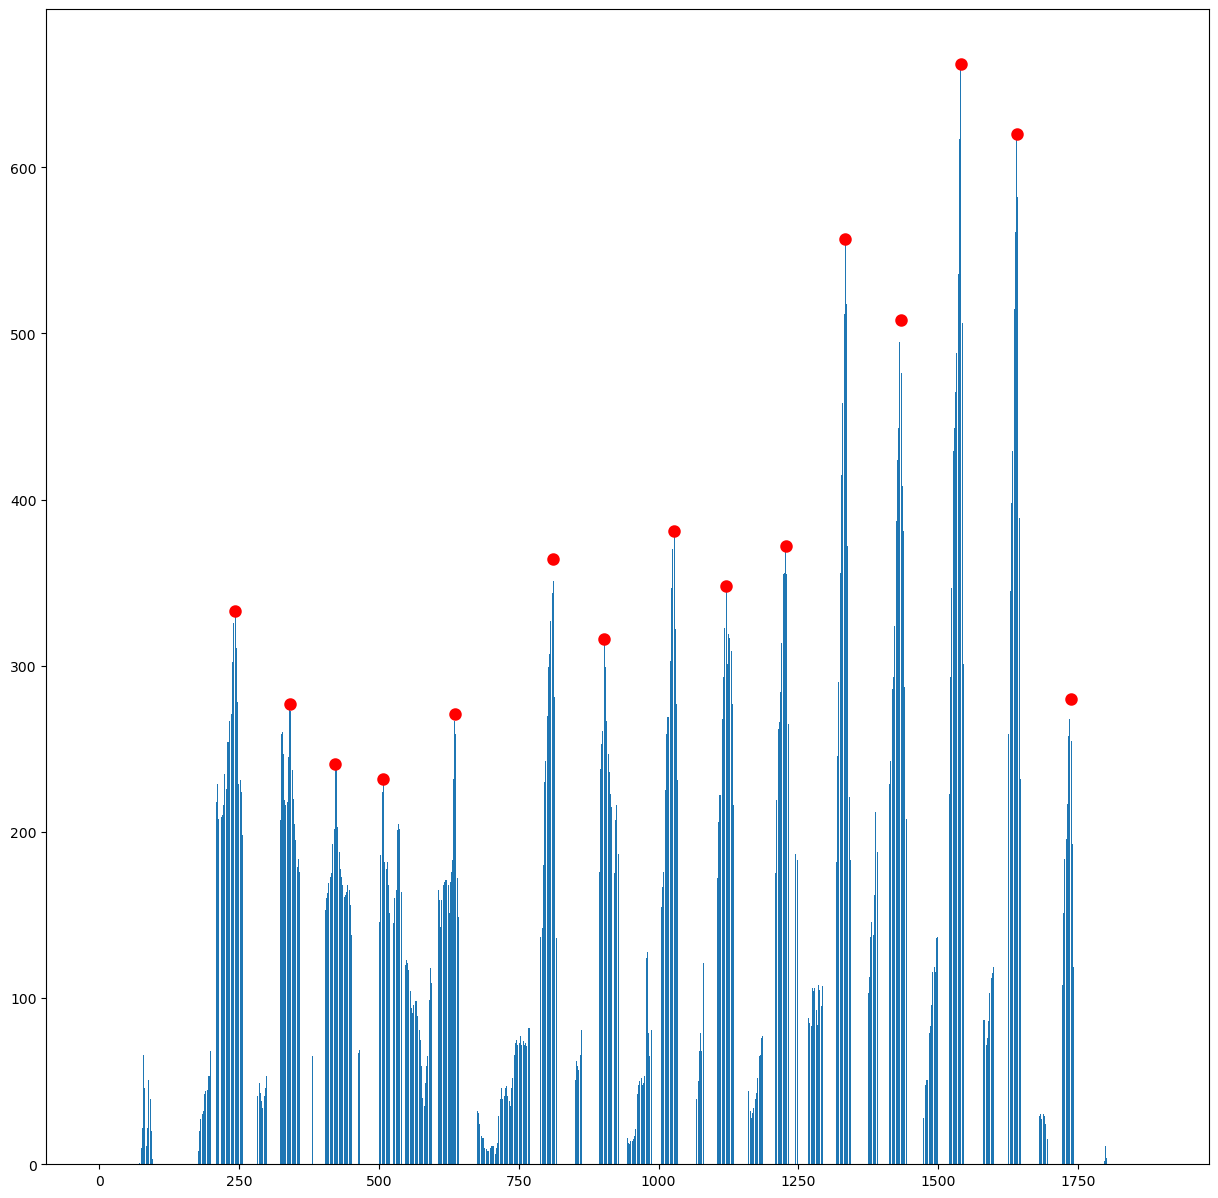

In [71]:
fig = plt.figure(figsize=(15, 15))
plt.bar(np.arange(len(boarders)), boarders)
plt.scatter(extrems, ones_img[extrems], c='r', linewidths=3)
plt.show()

In [141]:
def line_division(extremes):
    line_confines = []
    a = extremes[0] - 30
    b = extremes[0] + round((extremes[1] - extremes[0])/3)
    line_confines.append((a,b))
    for i in range(1, len(extremes)-1):
        a = extremes[i] - round((extremes[i] - extremes[i-1])/3)
        b = extremes[i] + round((extremes[i+1] - extremes[i])/3)
        line_confines.append((a,b))
    a = extremes[-1] - round((extremes[-1] - extremes[-2])/3)
    b = extremes[-1] + 30
    line_confines.append((a,b))
    return line_confines

In [142]:
division = line_division(extrems)
division

[(212, 275),
 (308, 368),
 (395, 450),
 (479, 550),
 (593, 694),
 (753, 842),
 (872, 945),
 (986, 1059),
 (1090, 1156),
 (1192, 1263),
 (1298, 1367),
 (1400, 1469),
 (1504, 1573),
 (1607, 1672),
 (1705, 1767)]

In [144]:
im2 = cv2.imread('test2-afterotsu.jpg')
im2.shape

(1890, 1606, 3)

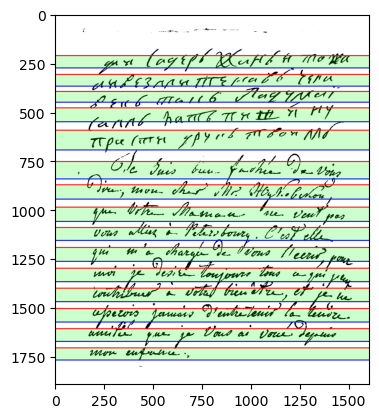

In [145]:
alpha = 0.2
for conf in division:
    im_copy = im2.copy()
    cv2.rectangle(im2, (0, conf[0]+2), (im2.shape[1], conf[1]-2), (0, 255, 0), cv2.FILLED)
    im2=cv2.addWeighted(im2, alpha, im_copy,1-alpha, gamma=0)
    cv2.line(im2,(0, conf[0]),(im2.shape[1], conf[0]),(255,0,0),3)
    cv2.line(im2,(0, conf[1]),(im2.shape[1], conf[1]),(0,0,255),3)
plt.imshow(im2)

In [102]:
def detect_confines_lines(extremes):
    line_confines = []
    a = extremes[0] - 80
    b = extremes[0] + round((extremes[1] - extremes[0])/2)
    line_confines.append((a,b))
    for i in range(1, len(extremes)-1):
        a = extremes[i] - round((extremes[i] - extremes[i-1])/2)
        b = extremes[i] + round((extremes[i+1] - extremes[i])/2)
        line_confines.append((a,b))
    a = extremes[-1] - round((extremes[-1] - extremes[-2])/2)
    b = extremes[-1] + 80
    line_confines.append((a,b))
    return line_confines

In [131]:
def division_strokes(strokes, extrems):
    confines_for_strokes = detect_confines_lines(extrems)
    res = []
    for stroke in strokes: # для каждого штриха
        n_lines = []
        for p in stroke[1]: # для каждой точки в штрихе
            j = 0
            while j+1 < len(confines_for_strokes) and p > confines_for_strokes[j+1][0]:
                j += 1
            n_lines.append(j)
        most_common_line = np.argmax(np.bincount(np.array(n_lines)))
        res.append(most_common_line)
    return res            

In [115]:
def parser(filename, image):
    abs, ord, width = [], [], []

    with open(filename, encoding='windows-1251') as f:
        content = f.read()
        content = content.replace(',', '.')
        content = list(content.split('\n'))

    strokes = []
    for i, el in enumerate(content[1:-2]):
        if el[0].isdigit():
            x, y, w = map(float, el.split())
            abs.append(x)
            ord.append(image.shape[0] - y)
            width.append(w)
        else:
            strokes.append((abs, ord, width))
            abs, ord, width = [], [], []

    return strokes

In [129]:
image = cv2.imread('test2-afterotsu.jpg')
strokes = parser('test2-afterotsu.txt', image)

In [136]:
n_lines = np.array(division_strokes(strokes, extrems))

In [137]:
unique, counts = np.unique(n_lines, return_counts=True)
dict(zip(unique, counts))

{0: 45,
 1: 36,
 2: 27,
 3: 39,
 4: 34,
 5: 39,
 6: 43,
 7: 50,
 8: 48,
 9: 49,
 10: 53,
 11: 55,
 12: 55,
 13: 46,
 14: 25}

In [139]:
ind0 = np.where(n_lines == 0)
ind7 = np.where(n_lines == 7)
ind0, ind7

((array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),),
 (array([260, 261, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
         276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
         289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
         302, 303, 304, 305, 306, 307, 308, 309, 312, 313, 314]),))